# 2022 NBA Champion Prediction

In [1]:
import os
import time
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from pandas import Series
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sqlalchemy import MetaData, and_, create_engine, select
from sqlalchemy.orm import DeclarativeBase, Session, aliased

### Notebook Constants

In [2]:
# Directories.
PROJECT_DIR = Path.cwd().parent
IMAGES_DIR = PROJECT_DIR / "machine_learning" / "images"

# Season to predict the champion for.
SEASON_CURRENT = 2022

# Seasons for the machine learning (ml) model.
SEASON_ML_START = 2016
SEASON_ML_END = SEASON_CURRENT - 1

# Image resolution.
IMAGE_DPI = 240.0

## Retrieve Stats
### Setup Database Connection and Mapped Classes
#### Construct Database URI

In [3]:
# Load database credentials as environment variables from .env file.
load_dotenv()

# Host, port, and database values.
db = os.environ.get("PGDATABASE")
host = os.environ.get("PGHOST")
port = os.environ.get("PGPORT")

# User credentials.
user = os.environ.get("PGUSER")
pwd = os.environ.get("PGPASSWORD")

# Build database URI.
db_uri = f"postgresql://{user}:{pwd}@{host}:{port}/{db}"

#### Create SQLAlchemy Engine and the Database Metadata Object
- The metadata object contains the properties for each of the database tables such as column names and data types, primary and foreign keys, constraints, etc.

In [4]:
# Create the connection to the database.
engine = create_engine(db_uri)

# Create the metadata object that will hold database table information.
metadata_obj = MetaData()
# Collect table information via database reflection.
metadata_obj.reflect(bind=engine)

#### ORM Mapped Classes
- A subclass of the SQLAlchemy `DeclarativeBase` class is required. This subclass, called `Base`, is then subclassed by each mapped class that will represent a table in the database.
- The mapped classes are "mapped" via the table metadata information (`metadata_obj`). See SQLAlchemy documentation for more info.

In [5]:
class Base(DeclarativeBase):
    pass


class Teams(Base):
    __table__ = metadata_obj.tables["teams"]


class Seasons(Base):
    __table__ = metadata_obj.tables["seasons"]


class SeasonRecords(Base):
    __table__ = metadata_obj.tables["season_records"]


class PlayoffRecords(Base):
    __table__ = metadata_obj.tables["playoff_records"]


class TeamsTraditional(Base):
    __table__ = metadata_obj.tables["teams_traditional"]


class TeamsAdvanced(Base):
    __table__ = metadata_obj.tables["teams_advanced"]


class TeamsMisc(Base):
    __table__ = metadata_obj.tables["teams_misc"]


class TeamsClutch(Base):
    __table__ = metadata_obj.tables["teams_clutch"]


class PlayoffsTraditional(Base):
    __table__ = metadata_obj.tables["playoffs_traditional"]


class PlayoffsAdvanced(Base):
    __table__ = metadata_obj.tables["playoffs_advanced"]


class PlayoffsMisc(Base):
    __table__ = metadata_obj.tables["playoffs_misc"]


class PlayoffsClutch(Base):
    __table__ = metadata_obj.tables["playoffs_clutch"]


class PlayoffTeamsLong(Base):
    __table__ = metadata_obj.tables["playoff_teams_long"]


class Champions(Base):
    __table__ = metadata_obj.tables["champions"]

### Retrieve and Verify
#### Build Query and Retrieve Tables Using `sqlalchemy`
- The query is a join of the traditional, advanced, and misc tables with season record information (the `PLAYOFFS` and `CHAMPION` columns are used). Seasons not representative of the modern era are filtered out. Non-playoff teams are also filtered out.

In [6]:
with Session(engine) as session:
    # Create aliases for each table to simplify the query below.
    tt = aliased(TeamsTraditional)
    ta = aliased(TeamsAdvanced)
    tm = aliased(TeamsMisc)
    sr = aliased(SeasonRecords)

    # Build a SQL query statement using SQLAlchemy `select` and its methods such as
    # `join` and `where` (the query is not executed at this point).
    query = (
        select(tt, ta, tm, sr.CHAMPION)
        .join(ta, and_(tt.SEASON == ta.SEASON, tt.TEAM == ta.TEAM))
        .join(tm, and_(tt.SEASON == tm.SEASON, tt.TEAM == tm.TEAM))
        .join(sr, and_(tt.SEASON == sr.SEASON, tt.TEAM == sr.TEAM))
        .where(tt.SEASON.between(SEASON_ML_START, SEASON_CURRENT), sr.PLAYOFFS == True)
    )

    # Use `read_sql` to execute the query on the database and return a DataFrame.
    start_time = time.perf_counter()
    stats = pd.read_sql(sql=query, con=engine)
    print(f"\ndatabase query execution time: {time.perf_counter() - start_time:.2f}s")

    # Drop redundant columns.
    stats = stats.drop(columns=["SEASON_1", "TEAM_1", "SEASON_2", "TEAM_2"])

    # Split the `stats` table into two tables, one containing the current season and one
    # containing the ml model seasons.
    current_stats = stats[stats["SEASON"] == SEASON_CURRENT]
    model_stats = stats[stats["SEASON"].between(SEASON_ML_START, SEASON_ML_END)]

    # The current season does not have a champion so the column is dropped.
    current_stats = current_stats.drop(columns="CHAMPION")

    current_stats = current_stats.reset_index(drop=True)
    model_stats = model_stats.reset_index(drop=True)


database query execution time: 0.50s


#### Check Results

In [7]:
current_stats.columns

Index(['SEASON', 'TEAM', 'WIN%', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
       'BLK', 'BLKA', 'PF', 'PFD', '+/-', 'OFFRTG', 'DEFRTG', 'NETRTG', 'AST%',
       'AST/TO', 'AST_RATIO', 'OREB%', 'DREB%', 'REB%', 'TOV%', 'EFG%', 'TS%',
       'PACE', 'PIE', 'POSS', 'PTS_OFF_TO', '2ND_PTS', 'FBPS', 'PITP',
       'OPP_PTS_OFF_TO', 'OPP_2ND_PTS', 'OPP_FBPS', 'OPP_PITP'],
      dtype='object')

In [8]:
current_stats["SEASON"].value_counts()

SEASON
2022    16
Name: count, dtype: int64

In [9]:
current_stats.head()

,SEASON,TEAM,WIN%,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,PIE,POSS,PTS_OFF_TO,2ND_PTS,FBPS,PITP,OPP_PTS_OFF_TO,OPP_2ND_PTS,OPP_FBPS,OPP_PITP
0,2022,Phoenix Suns,0.780,114.8,43.7,90.1,48.5,11.6,31.9,36.4,...,54.8,8242,18.1,12.1,12.5,49.8,14.8,13.6,11.3,45.2
1,2022,Memphis Grizzlies,0.683,115.6,43.5,94.4,46.1,11.5,32.7,35.3,...,53.0,8295,18.3,18.7,17.7,57.6,14.5,13.0,13.2,47.4
2,2022,Golden State Warriors,0.646,111.0,40.5,86.4,46.9,14.3,39.4,36.4,...,53.6,8121,17.6,12.6,13.8,44.7,16.9,12.7,12.3,43.9
3,2022,Miami Heat,0.646,110.0,39.6,84.8,46.7,13.6,35.8,37.9,...,52.9,7987,17.2,12.7,10.9,43.0,16.7,12.6,12.2,41.3
4,2022,Dallas Mavericks,0.634,108.0,39.3,85.1,46.1,13.1,37.4,35.0,...,51.1,7871,14.9,11.0,10.0,42.9,14.4,13.1,12.0,47.1


In [10]:
model_stats["SEASON"].value_counts()

SEASON
2021    16
2020    16
2019    16
2018    16
2017    16
2016    16
Name: count, dtype: int64

In [11]:
model_stats

,SEASON,TEAM,WIN%,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,POSS,PTS_OFF_TO,2ND_PTS,FBPS,PITP,OPP_PTS_OFF_TO,OPP_2ND_PTS,OPP_FBPS,OPP_PITP,CHAMPION
0,2021,Utah Jazz,0.722,116.4,41.3,88.1,46.8,16.7,43.0,38.9,...,7193,14.1,13.6,11.9,44.2,17.0,12.4,12.1,49.1,False
1,2021,Phoenix Suns,0.708,115.3,43.3,88.3,49.0,13.1,34.6,37.8,...,7137,16.1,12.9,13.1,45.3,14.8,12.4,12.0,47.4,False
2,2021,Philadelphia 76ers,0.681,113.6,41.4,86.9,47.6,11.3,30.1,37.4,...,7272,18.1,13.9,15.2,47.3,17.2,11.6,14.3,46.0,False
3,2021,Brooklyn Nets,0.667,118.6,43.1,87.3,49.4,14.2,36.1,39.2,...,7280,15.8,12.3,14.3,49.2,16.1,15.3,12.1,47.8,False
4,2021,Denver Nuggets,0.653,115.1,43.3,89.2,48.5,12.9,34.2,37.7,...,7123,18.0,13.8,12.4,49.7,15.6,11.3,13.4,45.2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2016,Detroit Pistons,0.537,102.0,37.9,86.4,43.9,9.0,26.2,34.5,...,7942,15.4,14.9,11.1,43.5,14.6,10.7,10.4,44.4,False
92,2016,Portland Trail Blazers,0.537,105.1,38.6,85.9,45.0,10.5,28.5,37.0,...,8012,14.8,14.1,10.7,39.1,16.3,12.4,11.1,40.9,False
93,2016,Dallas Mavericks,0.512,102.3,37.4,84.1,44.4,9.8,28.6,34.4,...,7950,16.0,10.6,11.2,38.0,14.8,13.4,16.0,40.9,False
94,2016,Memphis Grizzlies,0.512,99.1,36.8,83.6,44.0,6.1,18.5,33.1,...,7763,17.9,12.9,12.6,44.0,15.1,11.8,14.6,38.5,False


<br>
<hr>
<br>

## Feature Selection
### Definition
- feature - a stat type (i.e. a numeric column from the `model_stats` DataFrame)
### Outline
- Analyze the correlations between features as well as the cumulative explained variance using all features.
- Use the results to select the final features for the logistic regression model.
#### Analysis: All Features
1. Correlation coefficient matrix and heatmap.
1. Investigate maximum and 80th percentile correlations - identify the most independent features.
1. Use principal component analysis (PCA) to build a cumulative explained variance (CEV) plot.
1. Use the CEV plot to identify the number of features to aim for.
1. Select the features to be used in the model.
#### Analysis: Selected Features
1. Correlation coefficient matrix and heatmap.
1. CEV plot.

### Feature Selection Constants
- **Explanation of `percentile_corr_threshold`:** Each stat type has a collection of correlation coefficients (its correlation with each other stat type in the dataset). The 80th percentile value for each of these collections is calculated (see `percentile`). `percentile_corr_threshold` is used to filter these results to see which stat types have an 80th percentile value lower than the threshold. The threshold value represents a "low correlation". To sum up, the idea is to reveal which stat types have mostly (80%) low correlations (r < `percentile_corr_threshold`).

In [12]:
# Threshold for max correlation coefficient graph. No percentile concept here, simply
# max(r) < 0.80.
max_corr_threshold = 0.80

percentile = 0.80
# Threshold for percentile correlation coefficient graph. See explanation above.
percentile_corr_threshold = 0.35

### Feature Lists
#### All Features

In [13]:
# List with all stat types in the dataset.
all_features = [
    "WIN%",
    "PTS",
    "FGM",
    "FGA",
    "FG%",
    "3PM",
    "3PA",
    "3P%",
    "FTM",
    "FTA",
    "FT%",
    "OREB",
    "DREB",
    "REB",
    "AST",
    "TOV",
    "STL",
    "BLK",
    "BLKA",
    "PF",
    "PFD",
    "+/-",
    "OFFRTG",
    "DEFRTG",
    "NETRTG",
    "AST%",
    "AST/TO",
    "AST_RATIO",
    "OREB%",
    "DREB%",
    "REB%",
    "TOV%",
    "EFG%",
    "TS%",
    "PACE",
    "PIE",
    "POSS",
    "PTS_OFF_TO",
    "2ND_PTS",
    "FBPS",
    "PITP",
    "OPP_PTS_OFF_TO",
    "OPP_2ND_PTS",
    "OPP_FBPS",
    "OPP_PITP",
]

#### Selected Features (ML Model Features)

In [14]:
# Uncomment/comment to select/deselect features for the ml model.
selected_features = [
    # 'WIN%',
    # 'PTS',
    # 'FGM',
    # 'FGA',
    # 'FG%',
    # '3PM',
    # '3PA',
    "3P%",
    # 'FTM',
    # 'FTA',
    # 'FT%',
    # 'OREB',
    "DREB",
    # 'REB',
    # 'AST',
    # 'TOV',
    "STL",
    "BLK",
    # 'BLKA',
    # 'PF',
    # 'PFD',
    # '+/-',
    "OFFRTG",
    "DEFRTG",
    # 'NETRTG',
    # 'AST%',
    "AST/TO",
    # 'AST_RATIO',
    # 'OREB%',
    # 'DREB%',
    # 'REB%',
    # 'TOV%',
    # 'EFG%',
    # 'TS%',
    # 'PACE',
    # 'PIE',
    # 'POSS',
    # 'PTS_OFF_TO',
    # '2ND_PTS',
    # 'FBPS',
    # 'PITP',
    # 'OPP_PTS_OFF_TO',
    # 'OPP_2ND_PTS',
    # 'OPP_FBPS',
    # 'OPP_PITP'
]
print(f"Number of selected features: {len(selected_features)}")

Number of selected features: 7


### Test Train Split
- The initial test train split includes all features. Once the analysis on all features is complete and the final feature set selected, `selected_features` is used to filter out the stat types that will not be used in the ML model.
- Note that this feature selection is only applied to `X_train` and `X_test` and also later `target` since these are the DataFrames that contain the features (`y_train` and `y_test` are the arrays representing the labels of champion or non-champion)

In [15]:
# `X` contains the features and `y` contains the labels.
X = model_stats[all_features]
# Transform the `CHAMPION` column of model_stats using a `LabelEncoder` transformer to
# produce the labels.
le = LabelEncoder()
y = le.fit_transform(model_stats["CHAMPION"])

# Split the dataset into training and testing sets.
# Stratifying the data is important since we have 6 champions and 90 non-champions (a
# strong imbalance across the two groups).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

### Analysis: All Features
#### Correlation Coefficient Matrix

In [16]:
# Normalize the data so that all features have the same scale.
scaler_all = StandardScaler()
X_train_scaled_all = scaler_all.fit_transform(X_train)
# Convert `X_train_scaled` back into a DataFram in order to use the `corr` method
X_train_scaled_all = pd.DataFrame(X_train_scaled_all, columns=X_train.columns)
# Calculate the correlation matrix for all features.
corr_all = X_train_scaled_all.corr()

#### Heatmap

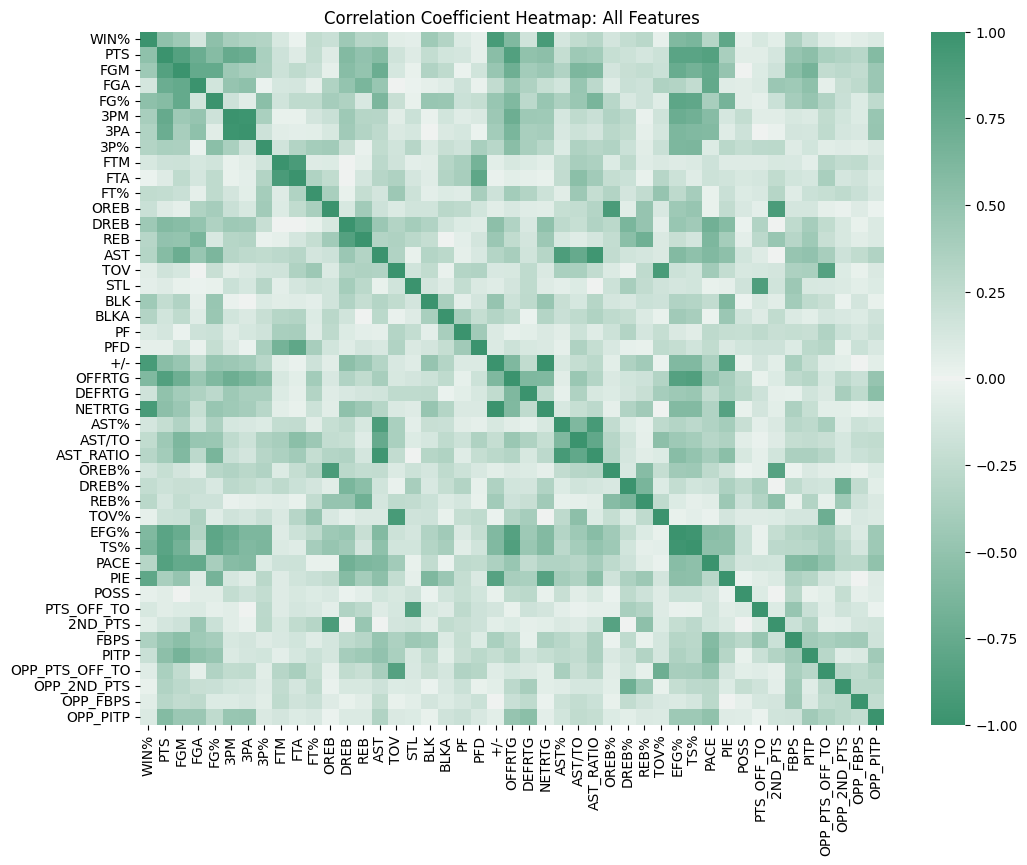

In [17]:
fig, ax = plt.subplots(figsize=(12, 9))
# Colormap.
cmap = sns.diverging_palette(150, 150, s=80, l=55, as_cmap=True)
# Heatmap of the correlations.
sns.heatmap(corr_all, cmap=cmap, vmin=-1, vmax=1)
ax.set_title("Correlation Coefficient Heatmap: All Features")

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "correlation_heatmap_all_features.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

#### Maximum and 80th Percentile Correlation Calculations

In [18]:
def get_percentile_corr(corr_col: Series, percentile: float = 1.0) -> float:
    """Returns the percentile value for a given Series `corr_col`.

    The default value for `percentile` will return the maximum value of the Series.
    """
    # The value at index 0 is removed since this is just the correlation of the stat
    # with itself.
    corr_col = corr_col.abs().sort_values(ascending=False)[1:]
    return corr_col.quantile(q=percentile)


# Apply `get_percentile_corr` to each column in `corr` using the default value for the
# percentile parameter to return max correlation values.
max_corrs = corr_all.agg(func=get_percentile_corr)
percentile_corrs = corr_all.agg(func=get_percentile_corr, percentile=percentile)

#### Filter Max Correlations Using Threshold

In [19]:
# Max correlation filtering.
max_corrs = max_corrs[max_corrs < max_corr_threshold].sort_values(ascending=False)

print(
    f"Number of stats with max(r) < {max_corr_threshold}: {len(max_corrs)} out of {len(all_features)}\n"
)
print(f"Stats with max(r) < {max_corr_threshold}: {list(max_corrs.index)}")

Number of stats with max(r) < 0.8: 17 out of 45

Stats with max(r) < 0.8: ['PFD', 'AST/TO', 'FGA', 'DREB%', 'OPP_2ND_PTS', 'REB%', 'PITP', '3P%', 'BLK', 'DEFRTG', 'OPP_PITP', 'FBPS', 'FT%', 'BLKA', 'OPP_FBPS', 'PF', 'POSS']


#### Max Correlations Plot

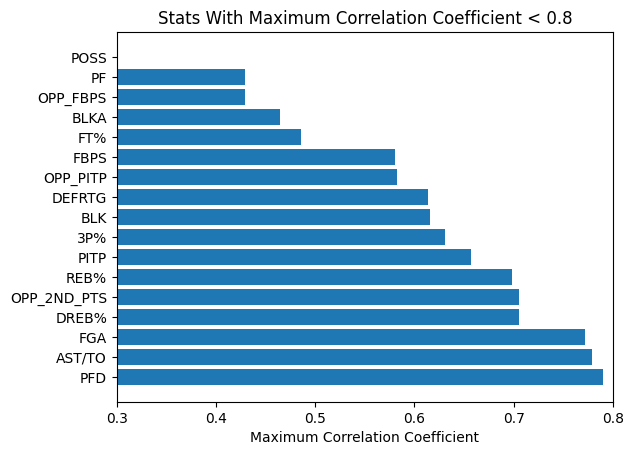

In [20]:
fig, ax = plt.subplots()
# Horizontal bar chart of max correlations.
ax.barh(max_corrs.index, max_corrs)
ax.set_title(f"Stats With Maximum Correlation Coefficient < {max_corr_threshold}")
ax.set_xlabel("Maximum Correlation Coefficient")
ax.set_xlim(0.3, 0.8)

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "max_correlation_coefficients.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

#### Filter Percentile Correlations Using Threshold

In [21]:
# Percentile correlation filtering.
percentile_corrs = percentile_corrs[
    percentile_corrs < percentile_corr_threshold
].sort_values(ascending=False)

print(
    f"Number of stats with {int(round(100*percentile))}th percentile r-value < {percentile_corr_threshold}: {len(percentile_corrs)} out of {len(all_features)}\n"
)
print(
    f"Stats with {int(round(100*percentile))}th percentile r-value < {percentile_corr_threshold}: {list(percentile_corrs.index)}\n"
)

Number of stats with 80th percentile r-value < 0.35: 18 out of 45

Stats with 80th percentile r-value < 0.35: ['TOV', 'BLK', 'FT%', 'DREB%', 'AST%', 'FTA', 'BLKA', 'OREB%', 'OPP_2ND_PTS', 'PF', 'PFD', 'TOV%', 'FTM', '2ND_PTS', 'OPP_FBPS', 'STL', 'POSS', 'PTS_OFF_TO']



#### Percentile Correlations Plot

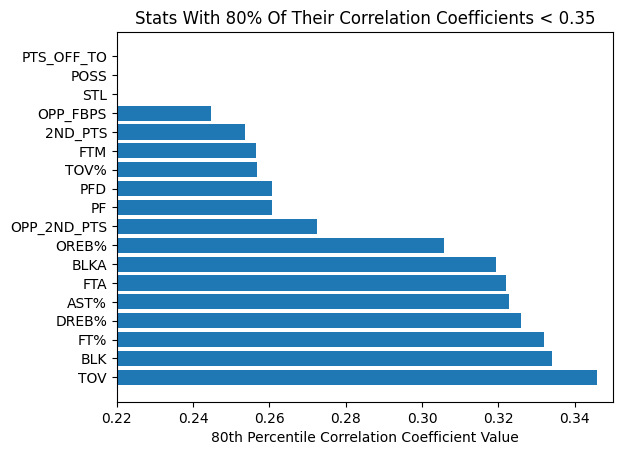

In [22]:
fig, ax = plt.subplots()
# Horizontal bar chart of 80th percentile correlations.
ax.barh(percentile_corrs.index, percentile_corrs)
ax.set_title(
    f"Stats With {int(round(100*percentile))}% Of Their Correlation Coefficients < {percentile_corr_threshold}"
)
ax.set_xlabel(
    f"{int(round(100*percentile))}th Percentile Correlation Coefficient Value"
)
ax.set_xlim(0.22, 0.35)

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "percentile_correlation_coefficients.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

#### Principal Component Analysis (PCA) and Cumulative Explained Variance (CEV)

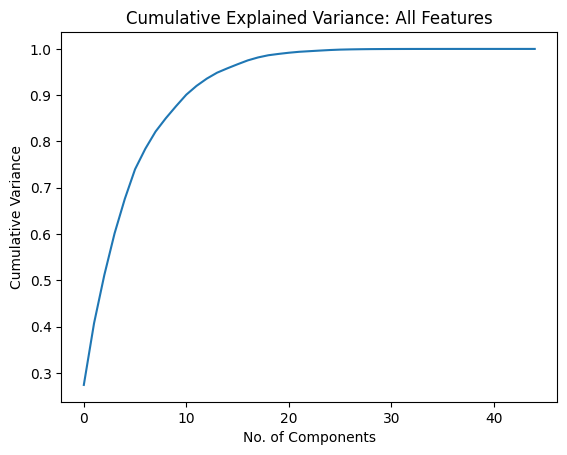

In [23]:
# Compute PCA using the scaled all feature stats ndarray.
pca_all = PCA(svd_solver="full").fit(X_train_scaled_all)

# Cumulative explained variance plot.
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca_all.explained_variance_ratio_))
ax.set_title("Cumulative Explained Variance: All Features")
ax.set_xlabel("No. of Components")
ax.set_ylabel("Cumulative Variance")

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "cumulative_explained_variance_all_features.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

### Analysis: Selected Features
#### Correlation Coefficient Matrix

In [24]:
# Normalize the data so that all features have the same scale.
scaler_selected = StandardScaler()
X_train_scaled_selected = scaler_selected.fit_transform(X_train[selected_features])
# Convert `X_train_scaled` back into a DataFram in order to use the `corr` method
X_train_scaled_selected = pd.DataFrame(
    X_train_scaled_selected, columns=X_train[selected_features].columns
)
# Calculate the correlation matrix for all features.
corr_selected = X_train_scaled_selected.corr()

#### Heatmap

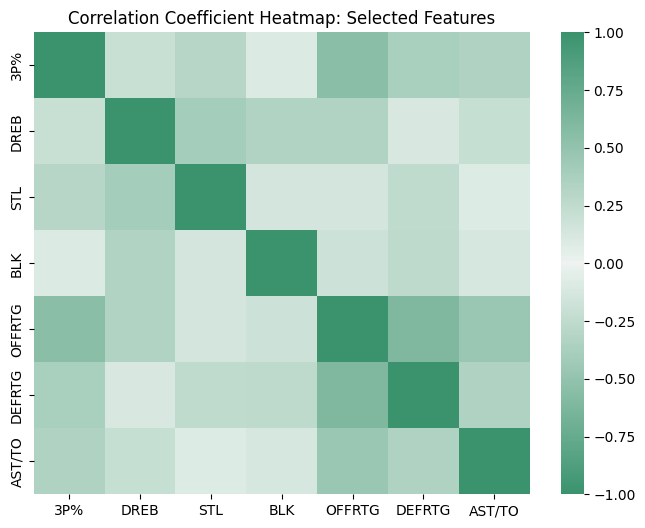

In [25]:
# Plot a heatmap of the correlations
fig, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(150, 150, s=80, l=55, as_cmap=True)
sns.heatmap(corr_selected, cmap=cmap, vmin=-1, vmax=1)
ax.set_title("Correlation Coefficient Heatmap: Selected Features")

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "correlation_heatmap_selected_features.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

#### Principal Component Analysis (PCA) and Cumulative Explained Variance (CEV)

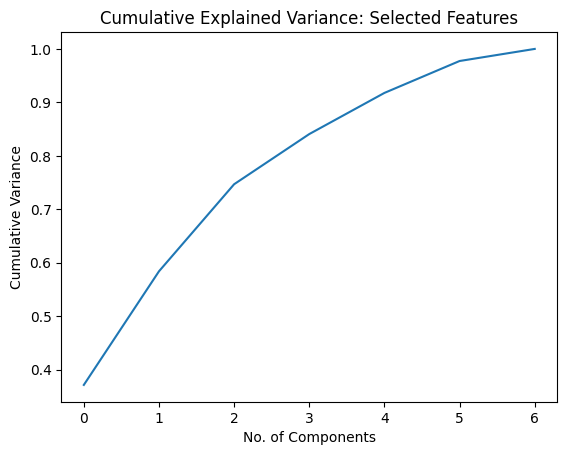

In [26]:
# Compute PCA using the scaled selected feature stats ndarray.
pca_selected = PCA(svd_solver="full").fit(X_train_scaled_selected)

# Cumulative explained variance plot.
fig, ax = plt.subplots()
ax.plot(np.cumsum(pca_selected.explained_variance_ratio_))
ax.set_title("Cumulative Explained Variance: Selected Features")
ax.set_xlabel("No. of Components")
ax.set_ylabel("Cumulative Variance")

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "cumulative_explained_variance_selected_features.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

<br>
<hr>
<br>

## Machine Learning
### Outline
1. Assign the supervised learning labels using the `"CHAMPION"` column of `model_stats`
1. Create a model with LogisticRegression().
1. Train the model with model.fit().
1. Make predictions with model.predict().
1. Validate the model with accuracy_score().

#### Scale `X_test` and `target`

In [27]:
# Scale the X_test to match the scaled `model_stats` DataFrame.
X_test_scaled = scaler_selected.transform(X_test[selected_features])
# Assign the target data to do the prediction on.
target_scaled = scaler_selected.transform(current_stats[selected_features])

### Train the Model

In [28]:
# Create a logistic regression model with the specified arguments.
classifier = LogisticRegression(solver="liblinear", max_iter=2000, random_state=1)

# Train the model with the training data
classifier.fit(X_train_scaled_selected, y_train)

LogisticRegression(max_iter=2000, random_state=1, solver='liblinear')

### Test and Validate the Model
#### Predict Using Test Data and Check Accuracy

In [29]:
# Create predictions for y-values
y_prediction = classifier.predict(X_test_scaled)

# Accuracy score
print(f"Accuracy: {round(accuracy_score(y_test, y_prediction), 2)}")

# Keep in mind that the test train split was stratified when viewing the
# `results` DataFrame.
results = pd.DataFrame({"Prediction": y_prediction, "Actual": y_test})
results

Accuracy: 0.96


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


#### Confusion Matrix

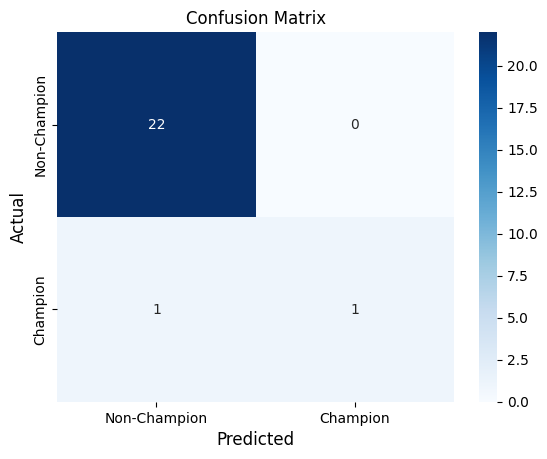

In [30]:
# Generate the confusion matrix.
confusion = confusion_matrix(y_test, y_prediction)

# Confusion matrix plot.
fig, ax = plt.subplots()
sns.heatmap(
    confusion,
    xticklabels=["Non-Champion", "Champion"],
    yticklabels=["Non-Champion", "Champion"],
    annot=True,
    cmap="Blues",
)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted", fontsize=12)
ax.set_ylabel("Actual", fontsize=12)

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "confusion_matrix.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()

### Predict the Champion
#### Predicted Labels

In [31]:
# Predict and print out the champion team.
current_prediction = classifier.predict(target_scaled)
champions = current_stats.iloc[current_prediction.nonzero()]["TEAM"]
champion_str = ", ".join(list(champions.array))
print(f"Predicted Champion: {champion_str}")

Predicted Champion: Memphis Grizzlies


#### Probability Estimates

In [32]:
# Calculate the probabilities for each class ("champion", and "not-champion") and for
# each team.
current_probabilities = classifier.predict_proba(target_scaled)
predicted_champion = pd.DataFrame(
    {
        "TEAM": current_stats["TEAM"],
        "Not-Champion": current_probabilities[:, 0],
        "Champion": current_probabilities[:, 1],
    }
)
predicted_champion = predicted_champion.round(2)
predicted_champion.sort_values(by="Champion", ascending=False)

,TEAM,Not-Champion,Champion
1,Memphis Grizzlies,0.42,0.58
12,Minnesota Timberwolves,0.79,0.21
0,Phoenix Suns,0.86,0.14
2,Golden State Warriors,0.88,0.12
5,Boston Celtics,0.89,0.11
7,Philadelphia 76ers,0.90,0.10
13,Brooklyn Nets,0.91,0.09
8,Utah Jazz,0.92,0.08
10,Toronto Raptors,0.92,0.08
6,Milwaukee Bucks,0.93,0.07


### Feature Importance
#### Coefficients and Relative Importance

In [33]:
# Calculate relative feature importance (relative to the maximum coefficient)
coefficients = classifier.coef_[0]
max = coefficients.max()
rel_importance = coefficients / max
feature_importance = (
    pd.DataFrame(
        rel_importance, index=selected_features, columns=["Relative Importance"]
    )
    .sort_values(by="Relative Importance", ascending=False)
    .round(2)
)
feature_importance

,Relative Importance
STL,1.00
BLK,0.93
OFFRTG,0.55
DREB,0.48
3P%,0.43
DEFRTG,0.18
AST/TO,0.13


#### Relative Feature Importance Plot

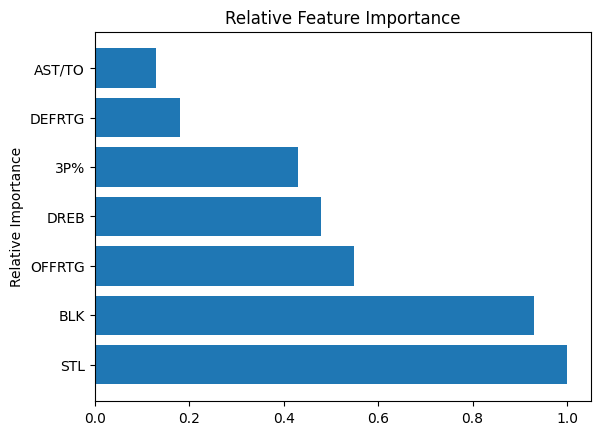

In [34]:
# Relative feature importance plot.
fig, ax = plt.subplots()
ax.barh(feature_importance.index, feature_importance["Relative Importance"])
ax.set_title("Relative Feature Importance")
ax.set_ylabel("Relative Importance")

# Save image to file.
fig.savefig(
    fname=IMAGES_DIR / "feature_importance.png",
    dpi=IMAGE_DPI,
    bbox_inches="tight",
)

plt.show()